# Purpose

2021-07-28
Let's install `"tensorflow-text == 2.3.0"` and see if the GPU is still detected after installing it.


---

Check whether GPUs are available/usable in current python environment.

**UPDATE:** With a fresh VM/notebook, we could see GPUs. This notebook runs the same code AFTER stopping and re-starting the VM. Maybe it's a problem with the way GCP handles the VM and not a problem created by installing new libraries?

Provenance:
- djb_01.03-test_gpus_available-instance-djb-subclu-inference-tf-2-3-20210630
- djb_01.031-test_gpus_available_AFTER_RESTART-instance-djb-subclu-inference-tf-2-3-20210630


# Debugging notes

## Sometimes the best fix is `sudo reboot`
When in doubt, open a terminal and do `sudo reboot`.

For some reason, the NVIDIA drivers might not be loaded properly after shutting down a VM instance from the GUI:
- https://console.cloud.google.com/ai-platform/notebooks/list/instances?project=data-prod-165221


In [1]:
!which python

/opt/conda/bin/python


# Imports & notebook setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
# Set logging higher BEFORE import TF
#   For some reason, this was broken in TF 2.3.4
#   https://github.com/tensorflow/tensorflow/issues/37649#issuecomment-599796966
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


from pprint import pprint
from pkg_resources import get_distribution

import tensorflow_text
import tensorflow as tf
from tensorflow.python.client import device_lib

import subclu
from subclu.utils.eda import (
    setup_logging, notebook_display_config, print_lib_versions,
)

print_lib_versions([tf, tensorflow_text, subclu])

python		v 3.7.10
===
tensorflow	v: 2.3.4
tensorflow_text	v: 2.3.0
subclu		v: 0.4.0


In [4]:
setup_logging()

# Check GPUs/XLA_GPUs recognized by Tensorflow/python

NOTE: `GPU`s and `XLA_GPU`s are recognized as two different device types.

https://www.tensorflow.org/xla
> **XLA: Optimizing Compiler for Machine Learning**
> XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
> 
> The results are improvements in speed and memory usage: e.g. in BERT MLPerf submission using 8 Volta V100 GPUs using XLA has achieved a ~7x performance improvement and ~5x batch size improvement

Other sources
- https://stackoverflow.com/questions/52943489/what-is-xla-gpu-and-xla-cpu-for-tensorflow


## List devices

Expected GPU output
```
Built with CUDA? True

GPUs
===
Num GPUs Available: 2
GPU details:
[   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
    PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

Built with CUDA? True

```

In [5]:
l_phys_gpus = (
    tf.config.list_physical_devices('GPU')  # + tf.config.list_physical_devices('XLA_GPU')
)

print(
    f"\nBuilt with CUDA? {tf.test.is_built_with_cuda()}"
    f"\n\nGPUs\n==="
    f"\nNum GPUs Available: {len(l_phys_gpus)}"
    f"\nGPU details:"
)
pprint(l_phys_gpus, indent=4,)


Built with CUDA? True

GPUs
===
Num GPUs Available: 4
GPU details:
[   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [6]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [7]:
# tf.config.list_physical_devices('GPU')

In [8]:
# l_all_local_devices = device_lib.list_local_devices()
# print(
#     f"\nBuilt with CUDA? {tf.test.is_built_with_cuda()}"
#     f"\n\nAll devices:\n==="
#     f"\nNum devices: {len(l_all_local_devices)}"
#     f"\nDetails:"
# )
# pprint(l_all_local_devices, indent=4,)

In [9]:
# !dpkg -l | grep nvidia

# Load config to test inference on a small batch

Also use this to make sure that we have access to the i18n bucket

In [10]:
import gc
import numpy as np
import pandas as pd
import tensorflow_hub as hub

from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadSubreddits, LoadPosts, LoadComments
from subclu.models.vectorize_text_tf import get_embeddings_as_df


config_data_v040 = LoadHydraConfig(
    config_path="../config/data_text_and_metadata",
    config_name='v0.4.0_19k_top_subs_and_geo_relevant_2021_09_27',
)

In [11]:
config_data_v040.config_dict

{'dataset_name': 'v0.4.0 inputs - Top Subreddits (no Geo) + Geo-relevant subs, comments: TBD',
 'bucket_name': 'i18n-subreddit-clustering',
 'folder_subreddits_text_and_meta': 'subreddits/top/2021-09-24',
 'folder_posts_text_and_meta': 'posts/top/2021-09-27',
 'folder_comments_text_and_meta': None}

## Load subreddit meta

In [12]:
%%time

df_sub_meta = LoadSubreddits(
    bucket_name=config_data_v040.config_dict['bucket_name'],
    folder_path=config_data_v040.config_dict['folder_subreddits_text_and_meta'],
    folder_posts=None,
    columns=None,
).read_raw()

07:49:04 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24"


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 158 ms, sys: 145 ms, total: 303 ms
Wall time: 415 ms


In [13]:
df_sub_meta.shape

(19262, 36)

In [14]:
df_sub_meta['subreddit_name_title_and_clean_descriptions'].head(10).str[:100].values

array(['AskReddit. \nAsk Reddit.... \nr AskReddit is the place to ask and answer thought provoking questions..',
       'pics. \nReddit Pics. \nA place for pictures and photographs.. \n[Rules](pics  index)\n\n1. No screenshots',
       "funny. \nfunny. \nWelcome to r Funny, Reddit's largest humour depository.. \n**Welcome to r Funny:**\n\n\n",
       'memes. \n/r/Memes the original since 2008. \nMemes!\n\nA way of describing cultural information being sh',
       'interestingasfuck. \nInteresting As Fuck. \nFor anything that is InterestingAsFuck. \nA place to share ',
       "HolUp. \nwhen you're itching for a spicy hol. \nFun for the whole family! ᵉˣᶜᵉᵖᵗ ᴬᵘⁿᵗ ˢᵘˢᵃⁿ. \nHol' up\n",
       'PublicFreakout. \n/r/PublicFreakout. \nA sub dedicated to people freaking out, melting down, losing th',
       'facepalm. \nA gallery of inexplicable stupidity. \n*A sub for you to share the stupidity of individual',
       'Unexpected. \nUnexpected. \nThis sub is for unexpected twists in videos and 

### Load USE-multilingual

NOTE: I had 2 notebooks running - the other notebook started first, and it caused an OOM (out of memory) error when trying to load the `large` version.

Remember to shut down other scripts/notebooks!
```
2021-10-01 02:29:43.934252: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.71MiB (rounded to 15421440)requested by op Identity
...
```

In [12]:
%%time
use_multi_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

CPU times: user 7.87 s, sys: 1.79 s, total: 9.67 s
Wall time: 8.9 s


In [51]:
%%time
use_multi = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

CPU times: user 2.4 s, sys: 531 ms, total: 2.93 s
Wall time: 2.59 s


In [31]:
del use_multi_large

In [17]:
gc.collect()

23

## Test inference times

In [18]:
n_char_limit_test = 750
n_batch_test = 2700
n_batch_test_large = 1000

series_text = df_sub_meta['subreddit_name_title_and_clean_descriptions'].str[:n_char_limit_test].head(n_batch_test)
series_text.shape

(2700,)

In [19]:
series_text.head()

0    AskReddit. \nAsk Reddit.... \nr AskReddit is t...
1    pics. \nReddit Pics. \nA place for pictures an...
2    funny. \nfunny. \nWelcome to r Funny, Reddit's...
3    memes. \n/r/Memes the original since 2008. \nM...
4    interestingasfuck. \nInteresting As Fuck. \nFo...
Name: subreddit_name_title_and_clean_descriptions, dtype: object

### Create 2 objects: embeddings and then convert to df

In [18]:
%%timeit

embeddings_test = use_multi_large(series_text[:n_batch_test_large])
df_vect = pd.DataFrame(embeddings_test.numpy())

6.73 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit

embeddings_test = use_multi(series_text)
df_vect = pd.DataFrame(embeddings_test.numpy())

1.48 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit

embeddings_test = use_multi(series_text)
df_vect = pd.DataFrame(embeddings_test.numpy())

1.47 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create a single df object
I'd expect this to be faster, but it looks like a wash, or maybe even worse than creating an intermediate embeddings object.

In [21]:
%%timeit

df_vect = pd.DataFrame(use_multi(series_text).numpy())

1.47 s ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit

df_vect = pd.DataFrame(use_multi(series_text).numpy())

1.47 s ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Use `np.array()` instead of TF's `.numpy()` method

I'd expect this to be a little slower, but it looks like if it is slower, it's not by much.

In [23]:
%%timeit

df_vect = pd.DataFrame(np.array(use_multi(series_text)))

1.48 s ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit

df_vect = pd.DataFrame(np.array(use_multi(series_text)))

1.49 s ± 5.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convert the dataframe to a list before creating embeddings

In most examples, it looks like the expected input is a list of embeddings. In previous versions of tf (e.g., 2.3.3), it looked like TF would process each row sequentially, so I used `.to_list()` because that was natively parallel.

Even though `.to_list()` now doesn't seem to be faster, I'll keep it for backwards compatibility.

In [25]:
%%timeit

embeddings_test2 = pd.DataFrame(
    use_multi(series_text.to_list()).numpy()
)

1.49 s ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit

embeddings_test2 = pd.DataFrame(
    use_multi(series_text.to_list()).numpy()
)

1.48 s ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### This was my old way... it's clearly slower so don't do it anymore
I was creating a list comprehension that now seems to waste time

In [27]:
%%timeit

embeddings_test2 = pd.DataFrame(
    np.array([emb.numpy() for emb in use_multi(series_text.to_list())])
)

1.93 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit

embeddings_test2 = pd.DataFrame(
    np.array([emb.numpy() for emb in use_multi(series_text.to_list())])
)

1.94 s ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### What if we just kept it as a numpy array?

Dang this is super fast... looks like most of the time is spent convering the np.array() into a DataFrame

In [56]:
%%timeit

embeddings_test = use_multi(series_text[:n_batch_test_large]).numpy()

505 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Inspect conversion example

In [32]:
%%time

embeddings_test = use_multi(series_text.to_list())

CPU times: user 1.74 s, sys: 34 ms, total: 1.78 s
Wall time: 1.49 s


In [33]:
embeddings_test.shape

TensorShape([2700, 512])

In [34]:
embeddings_test.numpy().shape

(2700, 512)

In [35]:
np.array(embeddings_test).shape

(2700, 512)

### Need to convert the raw embeddings output to make it a flat/df shape

In [41]:
pd.DataFrame(embeddings_test[:5])

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,"tf.Tensor(-0.0055558663, shape=(), dtype=float32)","tf.Tensor(-0.035515025, shape=(), dtype=float32)","tf.Tensor(-0.0022780034, shape=(), dtype=float32)","tf.Tensor(0.036515567, shape=(), dtype=float32)","tf.Tensor(0.07314272, shape=(), dtype=float32)","tf.Tensor(0.036497936, shape=(), dtype=float32)","tf.Tensor(0.049269363, shape=(), dtype=float32)","tf.Tensor(-0.04262645, shape=(), dtype=float32)","tf.Tensor(0.0523665, shape=(), dtype=float32)","tf.Tensor(-0.0005845973, shape=(), dtype=float32)",...,"tf.Tensor(0.069771625, shape=(), dtype=float32)","tf.Tensor(-0.020761905, shape=(), dtype=float32)","tf.Tensor(0.021816198, shape=(), dtype=float32)","tf.Tensor(-0.04700967, shape=(), dtype=float32)","tf.Tensor(0.010417417, shape=(), dtype=float32)","tf.Tensor(0.057876956, shape=(), dtype=float32)","tf.Tensor(0.059722144, shape=(), dtype=float32)","tf.Tensor(-0.0031177353, shape=(), dtype=float32)","tf.Tensor(-0.04763955, shape=(), dtype=float32)","tf.Tensor(0.07449764, shape=(), dtype=float32)"
1,"tf.Tensor(-0.05912168, shape=(), dtype=float32)","tf.Tensor(-0.0028184308, shape=(), dtype=float32)","tf.Tensor(0.02198541, shape=(), dtype=float32)","tf.Tensor(-0.0032862264, shape=(), dtype=float32)","tf.Tensor(0.044820715, shape=(), dtype=float32)","tf.Tensor(0.046669677, shape=(), dtype=float32)","tf.Tensor(0.046701834, shape=(), dtype=float32)","tf.Tensor(-0.067676745, shape=(), dtype=float32)","tf.Tensor(0.052850373, shape=(), dtype=float32)","tf.Tensor(-0.023734221, shape=(), dtype=float32)",...,"tf.Tensor(0.04174909, shape=(), dtype=float32)","tf.Tensor(-0.0035612562, shape=(), dtype=float32)","tf.Tensor(-0.05574649, shape=(), dtype=float32)","tf.Tensor(-0.05225738, shape=(), dtype=float32)","tf.Tensor(-0.008880128, shape=(), dtype=float32)","tf.Tensor(-0.019475382, shape=(), dtype=float32)","tf.Tensor(0.040921874, shape=(), dtype=float32)","tf.Tensor(-0.01874695, shape=(), dtype=float32)","tf.Tensor(0.027175335, shape=(), dtype=float32)","tf.Tensor(0.056929246, shape=(), dtype=float32)"
2,"tf.Tensor(0.06015646, shape=(), dtype=float32)","tf.Tensor(-0.04744803, shape=(), dtype=float32)","tf.Tensor(-0.02377507, shape=(), dtype=float32)","tf.Tensor(-0.03758738, shape=(), dtype=float32)","tf.Tensor(0.07512383, shape=(), dtype=float32)","tf.Tensor(0.06230174, shape=(), dtype=float32)","tf.Tensor(0.021927327, shape=(), dtype=float32)","tf.Tensor(0.052881956, shape=(), dtype=float32)","tf.Tensor(-0.03562096, shape=(), dtype=float32)","tf.Tensor(0.006802066, shape=(), dtype=float32)",...,"tf.Tensor(-0.04608957, shape=(), dtype=float32)","tf.Tensor(-0.0063478565, shape=(), dtype=float32)","tf.Tensor(-0.06315106, shape=(), dtype=float32)","tf.Tensor(0.0035429779, shape=(), dtype=float32)","tf.Tensor(0.035898563, shape=(), dtype=float32)","tf.Tensor(0.036796335, shape=(), dtype=float32)","tf.Tensor(0.048255075, shape=(), dtype=float32)","tf.Tensor(-0.0612688, shape=(), dtype=float32)","tf.Tensor(-0.007957812, shape=(), dtype=float32)","tf.Tensor(0.061666816, shape=(), dtype=float32)"
3,"tf.Tensor(-0.014804245, shape=(), dtype=float32)","tf.Tensor(0.0065776324, shape=(), dtype=float32)","tf.Tensor(-0.053259037, shape=(), dtype=float32)","tf.Tensor(-0.018393569, shape=(), dtype=float32)","tf.Tensor(0.06598462, shape=(), dtype=float32)","tf.Tensor(0.06567661, shape=(), dtype=float32)","tf.Tensor(-0.06568842, shape=(), dtype=float32)","tf.Tensor(0.040840585, shape=(), dtype=float32)","tf.Tensor(0.042672247, shape=(), dtype=float32)","tf.Tensor(0.04848014, shape=(), dtype=float32)",...,"tf.Tensor(0.06505672, shape=(), dtype=float32)","tf.Tensor(0.04214886, shape=(), dtype=float32)","tf.Tensor(-0.038975522, shape=(), dtype=float32)","tf.Tensor(-0.04867234, shape=(), dtype=float32)","tf.Tensor(-0.035740327, shape=(), dtype=float32)","tf.Tensor(0.04875293, shape=(), dtype=float32)","tf.Tensor(0.060423836, shape=(), dtype=float32)","tf.Tensor(-0.056467135, shape=(), dtype=float3

In [42]:
pd.DataFrame(embeddings_test.numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.005556,-0.035515,-0.002278,0.036516,0.073143,0.036498,0.049269,-0.042626,0.052366,-0.000585,...,0.069772,-0.020762,0.021816,-0.047010,0.010417,0.057877,0.059722,-0.003118,-0.047640,0.074498
1,-0.059122,-0.002818,0.021985,-0.003286,0.044821,0.046670,0.046702,-0.067677,0.052850,-0.023734,...,0.041749,-0.003561,-0.055746,-0.052257,-0.008880,-0.019475,0.040922,-0.018747,0.027175,0.056929
2,0.060156,-0.047448,-0.023775,-0.037587,0.075124,0.062302,0.021927,0.052882,-0.035621,0.006802,...,-0.046090,-0.006348,-0.063151,0.003543,0.035899,0.036796,0.048255,-0.061269,-0.007958,0.061667
3,-0.014804,0.006578,-0.053259,-0.018394,0.065985,0.065677,-0.065688,0.040841,0.042672,0.048480,...,0.065057,0.042149,-0.038976,-0.048672,-0.035740,0.048753,0.060424,-0.056467,0.047342,0.065621
4,-0.025694,0.074410,-0.043989,0.014121,0.070395,0.059654,0.040311,0.006704,-0.004545,0.046714,...,-0.026357,-0.002705,-0.073361,-0.033207,-0.006802,0.015830,0.049824,-0.012889,-0.047644,0.082755


In [43]:
np.allclose(pd.DataFrame(embeddings_test.numpy()), pd.DataFrame(np.array(embeddings_test)))

True

# Options for running in parallel

Above tests weren't great... seems like TF will only use one core at a time for GPU inference........ UGH
- This issue was opened in 2017 (and is still open w/o a solution)
    - https://github.com/tensorflow/serving/issues/311 
    
    
### Multiprocessing
So I would need to write custom code to manually split up the chunks and run the multi-process myself. This AWS blog post from 2 years ago provides a way to do it... but it might take some thinking to refactor.
- blog post
    - https://aws.amazon.com/blogs/machine-learning/parallelizing-across-multiple-cpu-gpus-to-speed-up-deep-learning-inference-at-the-edge/
- github repo
    - https://github.com/aws-samples/parallelize-ml-inference

### Use `dask.delayed()` instead of multiprocessing?
My mental model if `dask.delayed()` is better than `multiprocessing`, so maybe that's worth a shot?

### Spark?
- https://datasciencevademecum.com/2020/05/21/embedding-billions-of-text-documents-using-tensorflow-universal-sentence-encoder-on-top-of-spark-emr/https://datasciencevademecum.com/2020/05/21/embedding-billions-of-text-documents-using-tensorflow-universal-sentence-encoder-on-top-of-spark-emr/

### Manual Batching
This one seems to use TF sessions (those might be deprecated, though).
- https://medium.com/@sbp3624/tensorflow-multi-gpu-for-inferencing-test-time-58e952a2ed95

In [46]:
%%time

df_embeddings = get_embeddings_as_df(
    model=use_multi,
    df=df_sub_meta,
    col_text='subreddit_name_title_and_clean_descriptions',
    cols_index='subreddit_default_',
    limit_first_n_chars=1000,
    batch_size=2200,
)

05:50:26 | INFO | "Getting embeddings in batches of size: 2200"
  0%|                                                     | 0/9 [00:00<?, ?it/s]05:50:36 | WARNING | "
ResourceExhausted, lowering character limit
 OOM when allocating tensor with shape[573337,1280] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/EncoderDNN/CNN_layers/ngram_order_5/Ngram-5-Conv/concat_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_restored_function_body_66405]

Function call stack:
restored_function_body

"
100%|#############################################| 9/9 [00:23<00:00,  2.58s/it]

CPU times: user 17.3 s, sys: 265 ms, total: 17.6 s
Wall time: 23.6 s


using `nvidia-smi` we see that the above was only using one core:
```bash
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   81C    P0    68W /  70W |  14378MiB / 15109MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   2  Tesla T4            Off  | 00000000:00:06.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   3  Tesla T4            Off  | 00000000:00:07.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A     28693      C   /opt/conda/bin/python           14375MiB |
|    1   N/A  N/A     28693      C   /opt/conda/bin/python             219MiB |
|    2   N/A  N/A     28693      C   /opt/conda/bin/python             219MiB |
|    3   N/A  N/A     28693      C   /opt/conda/bin/python             219MiB |
+-----------------------------------------------------------------------------+
```

# Try `dask.delayed()`

## Try example first
- https://docs.dask.org/en/latest/delayed.html

In [20]:
import dask

In [21]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]


In [22]:
output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

In [46]:
# total.visualize()

In [24]:
%%time
total.compute()

CPU times: user 4.99 ms, sys: 4.53 ms, total: 9.52 ms
Wall time: 6.23 ms


50

## Run the embeddings on all 4 GPUs at the same time

Let's run the same text on all 4 GPUs. If they run in parallel, we should see the run time about the same as running the text 1 time in one GPU.

Note that we might have some more overhead b/c we'll need to load the model in each GPU.

In [36]:
from tqdm import tqdm

from subclu.models.vectorize_text_tf import get_embeddings_as_df_delayed

In [33]:
l_gpu_names = [gpu_.name.replace('physical_device:', '') for gpu_ in tf.config.list_physical_devices('GPU')]
l_gpu_names

['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3']

In [15]:
# %%time
# l_gpu_models = list()
# for gpu_ in l_gpu_names:
#     with tf.device(gpu_):
#         l_gpu_models.append(hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"))

In [34]:
l_gpu_models

[<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb625a97290>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5c862c690>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5b05bde50>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5680eef50>]

In [35]:
# loop through each GPU and get inference for each model
# this no longer works.. not sure what changed? is it serializing when we have a cluster??

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            get_embeddings_as_df_delayed(
                model=l_gpu_models[i],
                df=df_sub_meta,
                col_text='subreddit_name_title_and_clean_descriptions',
                cols_index='subreddit_default_',
                limit_first_n_chars=1000,
                batch_size=2200,
            )
        )
df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

In [40]:
# df_vect_delayed.visualize()

This did NOT run in parallel, it was sequential on one GPU

```
...
100%|#############################################| 9/9 [02:04<00:00, 13.79s/it]
100%|#############################################| 9/9 [02:05<00:00, 13.98s/it]
100%|#############################################| 9/9 [02:04<00:00, 13.87s/it]
100%|#############################################| 9/9 [02:05<00:00, 13.98s/it]
/opt/conda/lib/python3.7/site-packages/dask/core.py:121: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return func(*(_execute_task(a, cache) for a in args))
CPU times: user 2min 4s, sys: 11.6 s, total: 2min 16s
Wall time: 2min 8s

```

In [41]:
# %%time

# df_vect_delayed.compute()

## Let's try again, but this time let's start a cluster & workers

- https://docs.dask.org/en/latest/gpu.html

- https://www.youtube.com/watch?v=jLQ2wAwapRg&t=894s&ab_channel=Enthought


Start workers in command line

In [ ]:
# !CUDA_VISIBLE_DEVICES=0 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=1 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=2 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=3 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1

In [30]:
import dask
from tqdm import tqdm

from subclu.models.vectorize_text_tf import get_embeddings_as_df_delayed

In [24]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=0, scheduler_port=8786) # dask sets the default to 8 workers with 64 CPUs present
client = Client(cluster)  # 'scheduler:8786'

In [27]:
l_gpu_names = [gpu_.name.replace('physical_device:', '') for gpu_ in tf.config.list_physical_devices('GPU')]
l_gpu_names

['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3']

In [28]:
%%time
l_gpu_models = list()
for gpu_ in l_gpu_names:
    with tf.device(gpu_):
        l_gpu_models.append(hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"))

CPU times: user 12 s, sys: 3.23 s, total: 15.3 s
Wall time: 13.7 s


In [40]:
l_gpu_models

[<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7faf0853e6d0>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fae746c7610>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fae742514d0>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fae084c42d0>]

In [63]:
# # loop through each GPU and get inference for each model

# l_df_embeddings = list()

# for i, gpu_ in enumerate(l_gpu_names):
#     with tf.device(gpu_):
#         l_df_embeddings.append(
#             get_embeddings_as_df_delayed(
#                 model=l_gpu_models[i],
#                 df=df_sub_meta,
#                 col_text='subreddit_name_title_and_clean_descriptions',
#                 cols_index='subreddit_default_',
#                 limit_first_n_chars=1000,
#                 batch_size=2200,
#             )
#         )

# df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

In [64]:
# loop through each GPU and get inference for each model

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            dask.delayed(get_embeddings_as_df)(
                l_gpu_models[i],
                df_sub_meta.copy(),
                'subreddit_name_title_and_clean_descriptions',
                'subreddit_default_',
                'embeddings',
                False,
                1000,
                2200,
            )
        )

df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

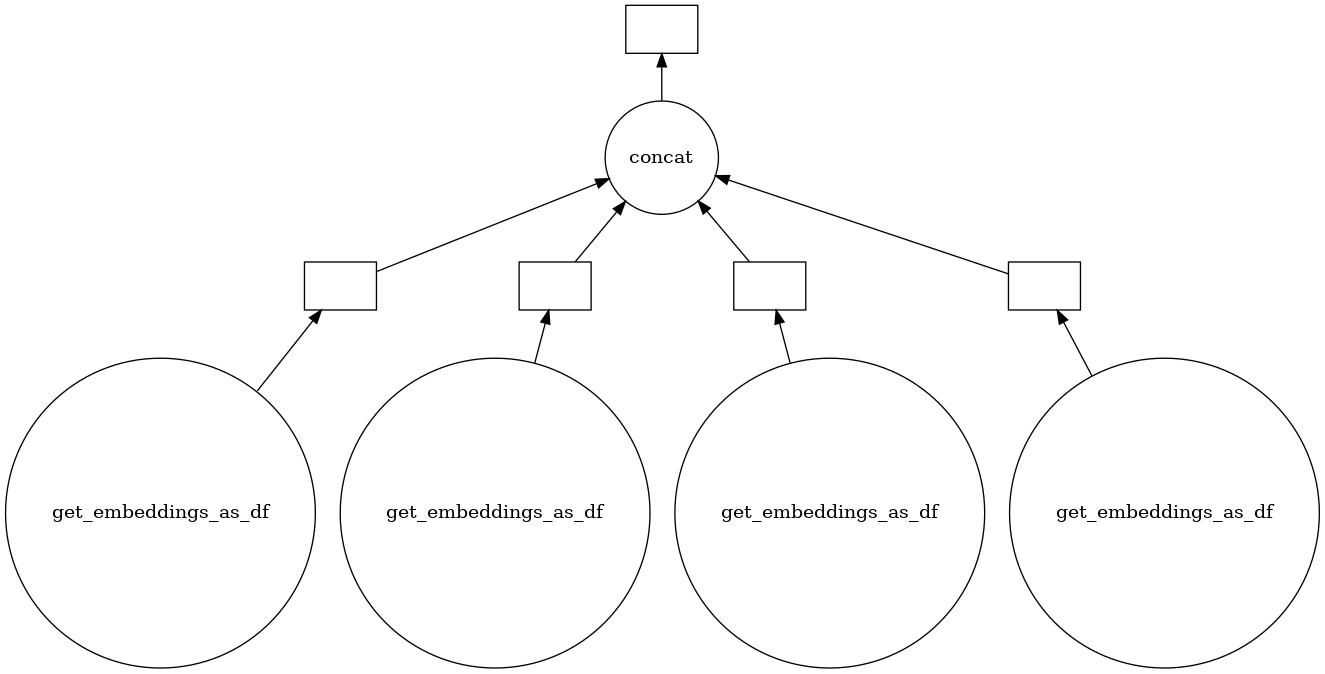

In [65]:
df_vect_delayed.visualize()

In [66]:
# workaround from https://github.com/uqfoundation/dill/issues/383
import dill
dill.extend(False)
import cloudpickle
dill.extend(True)

```
------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/opt/conda/lib/python3.7/site-packages/distributed/protocol/pickle.py in dumps(x, buffer_callback, protocol)
     48         buffers.clear()
---> 49         result = pickle.dumps(x, **dump_kwargs)
     50         if len(result) < 1000:

AttributeError: Can't pickle local object 'Loader._recreate_base_user_object.<locals>._UserObject'

During handling of the above exception, another exception occurred:

PickleError                               Traceback (most recent call last)
/tmp/ipykernel_12880/435696660.py in <module>
----> 1 df_vect_delayed.compute()

/opt/conda/lib/python3.7/site-packages/dask/base.py in compute(self, **kwargs)
    283         dask.base.compute
    284         """
--> 285         (result,) = compute(self, traverse=False, **kwargs)
    286         return result
    287 

```

In [68]:
# df_vect_delayed.compute()

In [56]:
# loop through each GPU and get inference for each model

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            dask.delayed(get_embeddings_as_df)(
                use_multi,
                df_sub_meta.copy(),
                # 'subreddit_name_title_and_clean_descriptions',
                # 'subreddit_default_',
                # 'embeddings',
                # False,
                # 1000,
                # 2200,
            )
        )

df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

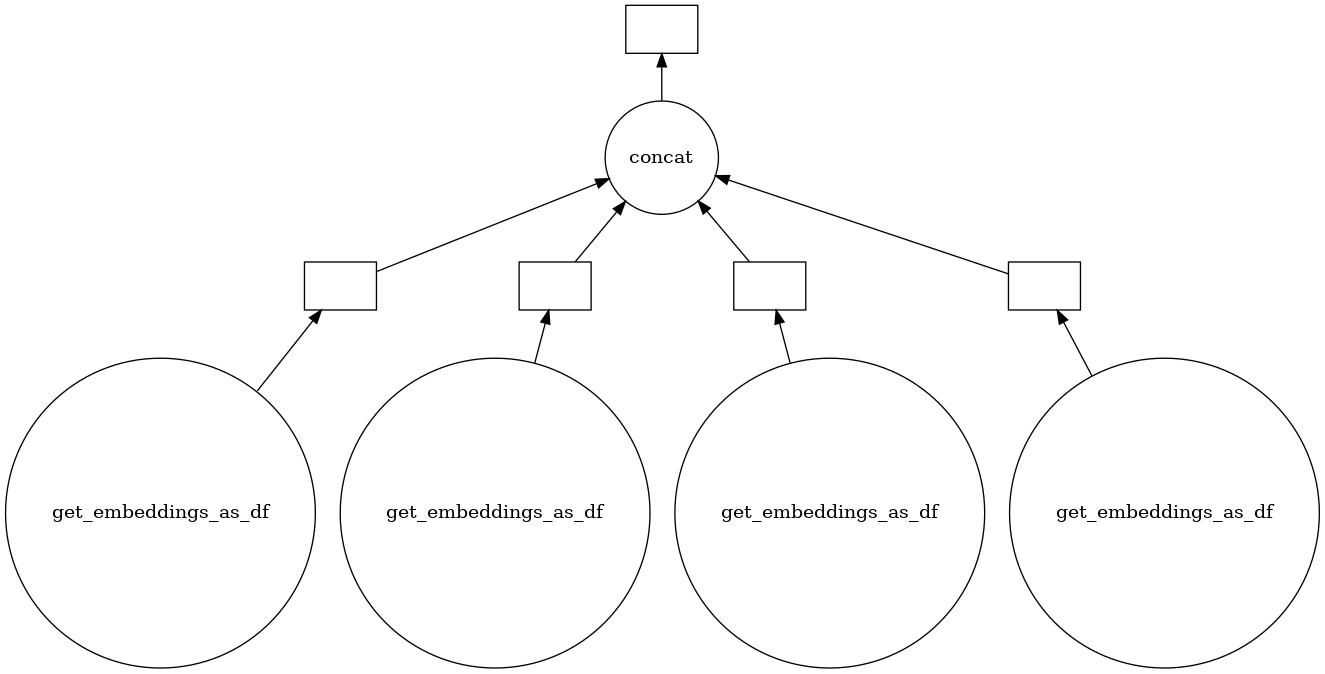

In [57]:
df_vect_delayed.visualize()

In [69]:
# df_vect_delayed.compute()

In [70]:
# # close or restart client & cluster
client.close()
cluster.close()

# cluster.restart()
# client.restart()